In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [3]:
df_full = pd.read_csv('Car_Price_Estimate_Dataset_small.csv', parse_dates=True)
# Take a look at the datatypes
#truncate the dataset
df = df_full.iloc[:156]
#print(df_full.describe())
print(df.shape)
df.head()

(156, 16)


,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.371
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.390
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.778


In [4]:
cols = df.columns
cols

Index(['Manufacturer', 'Model', 'Sales_in_thousands', '__year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')

In [5]:
cols = ['Price_in_thousands', 'Manufacturer', 'Model', 
       'Vehicle_type', 'Engine_size', 'Horsepower',
       'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor', '__year_resale_value','Sales_in_thousands']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
Manufacturer           156 non-null object
Model                  156 non-null object
Sales_in_thousands     156 non-null float64
__year_resale_value    121 non-null float64
Vehicle_type           156 non-null object
Price_in_thousands     154 non-null float64
Engine_size            155 non-null float64
Horsepower             155 non-null float64
Wheelbase              155 non-null float64
Width                  155 non-null float64
Length                 155 non-null float64
Curb_weight            154 non-null float64
Fuel_capacity          155 non-null float64
Fuel_efficiency        153 non-null float64
Latest_Launch          156 non-null object
Power_perf_factor      154 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.6+ KB


In [7]:
df=df[cols]
df= df.rename(columns={'Power_perf_factor': 'Power_factor', '__year_resale_value':'Resale_value' })
df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], format = "%m/%d/%Y" )

df=df.dropna()
df.head()

,Price_in_thousands,Manufacturer,Model,Vehicle_type,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_factor,Resale_value,Sales_in_thousands
0,21.50,Acura,Integra,Passenger,1.8,140.0,2.639,13.2,28.0,2012-02-02,58.280,16.360,16.919
1,28.40,Acura,TL,Passenger,3.2,225.0,3.517,17.2,25.0,2011-06-03,91.371,19.875,39.384
3,42.00,Acura,RL,Passenger,3.5,210.0,3.850,18.0,22.0,2011-03-10,91.390,29.725,8.588
4,23.99,Audi,A4,Passenger,1.8,150.0,2.998,16.4,27.0,2011-10-08,62.778,22.255,20.397
5,33.95,Audi,A6,Passenger,2.8,200.0,3.561,18.5,22.0,2011-08-09,84.565,23.555,18.780


In [8]:
df['Latest_Launch']=df['Latest_Launch'].dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 149
Data columns (total 13 columns):
Price_in_thousands    117 non-null float64
Manufacturer          117 non-null object
Model                 117 non-null object
Vehicle_type          117 non-null object
Engine_size           117 non-null float64
Horsepower            117 non-null float64
Curb_weight           117 non-null float64
Fuel_capacity         117 non-null float64
Fuel_efficiency       117 non-null float64
Latest_Launch         117 non-null object
Power_factor          117 non-null float64
Resale_value          117 non-null float64
Sales_in_thousands    117 non-null float64
dtypes: float64(9), object(4)
memory usage: 12.8+ KB


In [9]:
df['Diff'] = np.array([pd.datetime.now().date()-d for d in df['Latest_Launch']])
df['Diff'] = df['Diff'].astype(str)
df['Diff'] = df['Diff'].str.split(' ').str[0]
df['Diff']=df['Diff'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 149
Data columns (total 14 columns):
Price_in_thousands    117 non-null float64
Manufacturer          117 non-null object
Model                 117 non-null object
Vehicle_type          117 non-null object
Engine_size           117 non-null float64
Horsepower            117 non-null float64
Curb_weight           117 non-null float64
Fuel_capacity         117 non-null float64
Fuel_efficiency       117 non-null float64
Latest_Launch         117 non-null object
Power_factor          117 non-null float64
Resale_value          117 non-null float64
Sales_in_thousands    117 non-null float64
Diff                  117 non-null int64
dtypes: float64(9), int64(1), object(4)
memory usage: 13.7+ KB


In [10]:
#df[df.isnull()]
df.isnull().values.any()

False

In [11]:
cols = ['Price_in_thousands', 'Engine_size', 'Horsepower','Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Diff', 'Resale_value','Sales_in_thousands', 'Manufacturer', 'Model','Vehicle_type']
df = df[cols]
df.head()

,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Diff,Resale_value,Sales_in_thousands,Manufacturer,Model,Vehicle_type
0,21.50,1.8,140.0,2.639,13.2,28.0,2913,16.360,16.919,Acura,Integra,Passenger
1,28.40,3.2,225.0,3.517,17.2,25.0,3157,19.875,39.384,Acura,TL,Passenger
3,42.00,3.5,210.0,3.850,18.0,22.0,3242,29.725,8.588,Acura,RL,Passenger
4,23.99,1.8,150.0,2.998,16.4,27.0,3030,22.255,20.397,Audi,A4,Passenger
5,33.95,2.8,200.0,3.561,18.5,22.0,3090,23.555,18.780,Audi,A6,Passenger


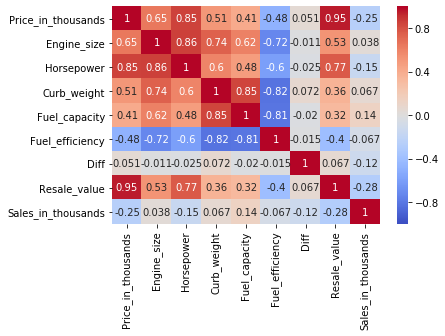

In [12]:
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1);

In [13]:
# drop features that show dependency on another feature. 

In [14]:
#sns.pairplot(df, height=1.2, aspect=1.5, hue='Manufacturer');

## OLS with Statsmodels - Patsies

In [15]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Price_in_thousands ~ Engine_size + Diff + Horsepower + Curb_weight + Fuel_capacity + Fuel_efficiency + Resale_value + Sales_in_thousands', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit1 = model.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Price_in_thousands   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     323.0
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           9.86e-72
Time:                        09:55:54   Log-Likelihood:                -287.40
No. Observations:                 117   AIC:                             592.8
Df Residuals:                     108   BIC:                             617.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -17.3009      6.579     -2.630      0.010     -30.342      -4.259
Engine_size           -0.0598      0.703     -0.085      0.932      -1.454       1.334
Diff                  -0.0010      0.001     -0.843      0.401      -0.003       0.001
Horsepower             0.0459      0.014      3.226      0.002       0.018       0.074
Curb_weight            6.3326      1.071      5.915      0.000       4.211       8.455
Fuel_capacity         -0.3452      0.153     -2.251      0.026      -0.649      -0.041
Fuel_efficiency        0.2629      0.124      2.117      0.037       0.017       0.509
Resale_value           0.9433      0.043     22.077      0.000       0.859       1.028
Sales_in_thousands    -0.0021      0.004     -0.528      0.598      -0.010       0.006
==============================================================================
Omnibus:                       15.343   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.887
Skew:                           0.492   Prob(JB):                     1.19e-07
Kurtosis:                       5.361   Cond. No.                     7.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Removing features

In [16]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Price_in_thousands ~ Horsepower + Curb_weight + Fuel_capacity + Fuel_efficiency + Resale_value', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit2 = model.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Price_in_thousands   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     526.3
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           1.51e-75
Time:                        09:55:54   Log-Likelihood:                -287.91
No. Observations:                 117   AIC:                             587.8
Df Residuals:                     111   BIC:                             604.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -20.3996      5.493     -3.713      0.000     -31.285      -9.514
Horsepower          0.0465      0.009      5.228      0.000       0.029       0.064
Curb_weight         6.1483      1.007      6.108      0.000       4.154       8.143
Fuel_capacity      -0.3353      0.148     -2.263      0.026      -0.629      -0.042
Fuel_efficiency     0.2678      0.120      2.233      0.028       0.030       0.506
Resale_value        0.9438      0.038     25.013      0.000       0.869       1.019
==============================================================================
Omnibus:                       15.069   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.618
Skew:                           0.491   Prob(JB):                     2.25e-07
Kurtosis:                       5.306   Cond. No.                     3.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking for Interaction Parameters

In [17]:
df['Weight_x_Resale_value']=df['Curb_weight']*df['Resale_value']
df_full = df.copy()
df_full.head()

,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Diff,Resale_value,Sales_in_thousands,Manufacturer,Model,Vehicle_type,Weight_x_Resale_value
0,21.50,1.8,140.0,2.639,13.2,28.0,2913,16.360,16.919,Acura,Integra,Passenger,43.174
1,28.40,3.2,225.0,3.517,17.2,25.0,3157,19.875,39.384,Acura,TL,Passenger,69.900
3,42.00,3.5,210.0,3.850,18.0,22.0,3242,29.725,8.588,Acura,RL,Passenger,114.441
4,23.99,1.8,150.0,2.998,16.4,27.0,3030,22.255,20.397,Audi,A4,Passenger,66.720
5,33.95,2.8,200.0,3.561,18.5,22.0,3090,23.555,18.780,Audi,A6,Passenger,83.879


In [18]:
cols = [ 'Price_in_thousands', 'Sales_in_thousands', 'Engine_size', 'Horsepower', 'Fuel_capacity', 'Fuel_efficiency','Weight_x_Resale_value','Diff','Manufacturer', 'Model','Vehicle_type']
df2 = df_full[cols]
df2.head()

,Price_in_thousands,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Weight_x_Resale_value,Diff,Manufacturer,Model,Vehicle_type
0,21.50,16.919,1.8,140.0,13.2,28.0,43.174,2913,Acura,Integra,Passenger
1,28.40,39.384,3.2,225.0,17.2,25.0,69.900,3157,Acura,TL,Passenger
3,42.00,8.588,3.5,210.0,18.0,22.0,114.441,3242,Acura,RL,Passenger
4,23.99,20.397,1.8,150.0,16.4,27.0,66.720,3030,Audi,A4,Passenger
5,33.95,18.780,2.8,200.0,18.5,22.0,83.879,3090,Audi,A6,Passenger


In [19]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Price_in_thousands ~ Horsepower + Fuel_efficiency + Weight_x_Resale_value', data=df2, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit4 = model.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Price_in_thousands   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1073.
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           7.78e-83
Time:                        09:55:54   Log-Likelihood:                -277.57
No. Observations:                 117   AIC:                             563.1
Df Residuals:                     113   BIC:                             574.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -7.2628      2.393     -3.036      0.003     -12.003      -2.523
Horsepower                0.0577      0.008      7.606      0.000       0.043       0.073
Fuel_efficiency           0.2659      0.069      3.830      0.000       0.128       0.404
Weight_x_Resale_value     0.2620      0.009     28.065      0.000       0.243       0.280
==============================================================================
Omnibus:                        7.597   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               13.978
Skew:                           0.115   Prob(JB):                     0.000922
Kurtosis:                       4.678   Cond. No.                     2.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

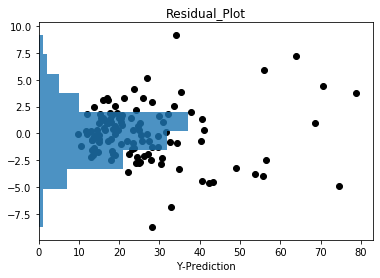

In [20]:
plt.figure(figsize=(6,4))
plt.hist(fit4.resid, bins=10, orientation='horizontal', alpha=0.8);
plt.scatter(fit4.predict(), fit4.resid, color='black');
plt.title('Residual_Plot')
plt.xlabel('Y-Prediction')
plt.show()

## LR with sklearn

### LR with 7 Parameters

In [21]:
cols = [ 'Price_in_thousands', 'Sales_in_thousands', 'Engine_size', 'Horsepower', 'Fuel_capacity', 'Fuel_efficiency', 'Diff','Weight_x_Resale_value']
df3 = df_full[cols]
df3.head()

,Price_in_thousands,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Diff,Weight_x_Resale_value
0,21.50,16.919,1.8,140.0,13.2,28.0,2913,43.174
1,28.40,39.384,3.2,225.0,17.2,25.0,3157,69.900
3,42.00,8.588,3.5,210.0,18.0,22.0,3242,114.441
4,23.99,20.397,1.8,150.0,16.4,27.0,3030,66.720
5,33.95,18.780,2.8,200.0,18.5,22.0,3090,83.879


In [22]:

# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df3.iloc[:, 1:]

# Choose the response variable(s)
y = df3.iloc[:, 0]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
print('R-squared value is:',lr.score(X,y))
# print out intercept
print('intercept is:', lr.intercept_)

# print out other coefficients
print('Coefficients are:', lr.coef_)

# note how much more elegant statsmodel renders results; yet, sklearn's raw values are easier to capture

R-squared value is: 0.9698204056702437
intercept is: 9.110895737502613
Coefficients are: [-1.51759744e-05 -8.55842415e-01  6.65324638e-02 -3.13397647e-01
 -2.17296156e-02 -9.97385888e-04  2.63936838e-01]


## Machine Learning with Train-Test Split

### Machine Learning with Train-Test Split with 7 Parameters

In [23]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

split_and_validate(X, y)


Validation R^2 score was: 0.9110551278893155
Feature coefficient results: 

Sales_in_thousands : -0.00
Engine_size : -0.84
Horsepower : 0.06
Fuel_capacity : -0.33
Fuel_efficiency : -0.02
Diff : -0.00
Weight_x_Resale_value : 0.27


### Machine Learning with Train-Test Split with 3 Parameters

In [24]:
cols = [ 'Price_in_thousands', 'Horsepower', 'Fuel_efficiency', 'Weight_x_Resale_value']
df4 = df_full[cols]
df4.head()

,Price_in_thousands,Horsepower,Fuel_efficiency,Weight_x_Resale_value
0,21.50,140.0,28.0,43.174
1,28.40,225.0,25.0,69.900
3,42.00,210.0,22.0,114.441
4,23.99,150.0,27.0,66.720
5,33.95,200.0,22.0,83.879


In [25]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df4.iloc[:, 1:]

# Choose the response variable(s)
y = df4.iloc[:, 0]

def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

split_and_validate(X, y)



Validation R^2 score was: 0.9150095636763836
Feature coefficient results: 

Horsepower : 0.05
Fuel_efficiency : 0.29
Weight_x_Resale_value : 0.27


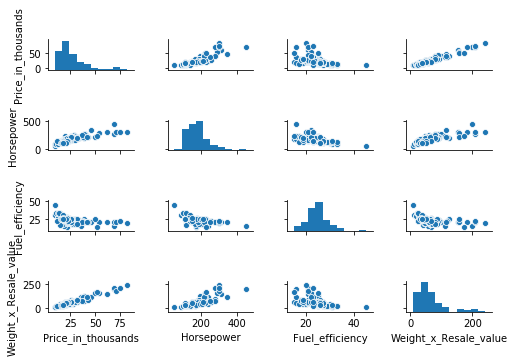

In [26]:
sns.pairplot(df4, height=1.2, aspect=1.5);

In [34]:
X = df4.iloc[:, 1:]
y = df4.iloc[:, 0]
X.shape

(117, 3)

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.style as style

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import lars_path
style.use('fivethirtyeight')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=50) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
#X, y = np.array(X), np.array(y)
kf = KFold(n_splits=4,shuffle=True, random_state=1)
#print(X)

In [37]:
lr_r2 = []
l1_r2 = []
l2_r2 = []

lr_rmse = []
l1_rmse = []
l2_rmse = []

Y_lr_predicted = []
Y_ridge_predicted = []
Y_lasso_predicted =[]

for tr,te in kf.split(X,y):
#     print("Fold")
    
    lr = LinearRegression()
    l1 = Ridge(alpha=0.1)
    l2 = Lasso(alpha=0.01)
    
    X_tr,X_te = X.iloc[tr] ,X.iloc[te]
    y_tr,y_te = y.iloc[tr] ,y.iloc[te]
    
    scale = StandardScaler()
    #scale.fit(X_tr)
    X_tr_sc = scale.fit_transform(X_tr)
    X_te_sc = scale.transform(X_te)
    
    lr.fit(X_tr_sc,y_tr)
#     print("L1")
    l1.fit(X_tr_sc,y_tr)
#     print("L2")
    l2.fit(X_tr_sc,y_tr)
    
    lr_r2.append(r2_score(y_te,lr.predict(X_te_sc)))
    l1_r2.append(r2_score(y_te,l1.predict(X_te_sc)))
    l2_r2.append(r2_score(y_te,l2.predict(X_te_sc)))
    
    Y_lr_predicted = lr.predict(X)
    Y_ridge_predicted = l1.predict(X)
    Y_lasso_predicted = l2.predict(X)
    
    lr_rmse.append(np.sqrt(mean_squared_error(y_te,lr.predict(X_te_sc))))
    l1_rmse.append(np.sqrt(mean_squared_error(y_te,l1.predict(X_te_sc))))
    l2_rmse.append(np.sqrt(mean_squared_error(y_te,l2.predict(X_te_sc))))


print(f'Lin_Reg Rsquared Value:{np.mean(lr_r2)}, RMSE: {np.mean(lr_rmse)}')
print('\r\n')
print(f'Ridge Rsquared Value:{np.mean(l1_r2)}, RMSE: {np.mean(l1_rmse)}') 
print('\r\n')
print(f'Lasso Rsquared Value:{np.mean(l2_r2)}, RMSE: {np.mean(l2_rmse)}')

for feature, coef in zip(X.columns, lr.coef_):
    print(feature, ':', f'{coef:.2f}') 
#print(X)
#print(Y_lr_predicted)

Lin_Reg Rsquared Value:0.9569909908669159, RMSE: 2.713244013670137


Ridge Rsquared Value:0.9570615444708561, RMSE: 2.7137024858691645


Lasso Rsquared Value:0.9570477439173414, RMSE: 2.7136924446613837
Horsepower : 3.26
Fuel_efficiency : 1.26
Weight_x_Resale_value : 11.74
